In [3]:
%matplotlib inline
%load_ext rpy2.ipython


import datetime as dt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import statsmodels.api as sm
from pykalman import KalmanFilter
import numpy.ma as ma
import scipy.linalg as linalg
import statsmodels.api as sm

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

# pd.set_option('max_rows', 20)
pd.set_option('max_rows', 100)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [4]:
utils = importr("MARSS")

# Data

## Regressors

In [5]:
data = pd.read_excel("Nowcasting.xlsx",sheetname="Valores")
# data.head()
series = data.loc[0,:][~data.loc[0,:].isnull()].tolist()
data.columns = data.iloc[0]

In [6]:
# i=data.columns.get_loc("MXWO Index")
# data.iloc[1:,i:i+2]

dfsList = []

for serie in series:
    i = data.columns.get_loc(serie)
    df = data.iloc[1:,i:i+2]
    df.set_index(serie,inplace=True)
    df.columns = [serie]
    df = df.loc[~df.index.duplicated(keep='first')]
    if not df[serie].isnull().all():
        dfsList.append(df.apply(pd.to_numeric))

data = pd.concat(dfsList,axis=1)
data.sort_index(inplace=True)
if data.loc[data.index[-1]].notnull().any() == False:
    data.drop(data.index[-1],inplace=True)
data.tail()

,BZGDINDX Index,BZIPTLYo Index,MPMIBRMA Index,BZGDGNDI Index,BZUETOTN Index,BFOETTOD Index,BZGDFNCE Index,BZREELHT Index,BPPICM Index,BZPIIPCM Index,...,BZRTFBSA INDEX,BZFGCCSA INDEX,ibov index,CL1 Comdty,BCSWLPD CURNCY,bcswfpd curncy,BZMOTRFB INDEX,BZJCGTOT INDEX,BZEANSA INDEX,OEBRD002 INDEX
2017-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,66190.63,53.78,10.6000,10.9178,475.0,NaN,NaN,NaN
2017-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,66033.98,53.17,10.5096,10.8762,-474.0,NaN,NaN,NaN
2017-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,64301.73,52.63,10.5724,10.8627,NaN,NaN,NaN,NaN
2017-01-31,NaN,NaN,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,79.3,64670.78,52.81,10.5262,10.8029,NaN,NaN,NaN,NaN
2017-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,65084.65,53.74,10.4928,10.8046,NaN,NaN,NaN,NaN


In [7]:
data.loc[data.index[-1]].notnull().any()

True

In [8]:
# # CutSample
# data = data.loc[dt.datetime(2008,1,1):]
# data

### Transformations


In [9]:
data.columns

Index(['BZGDINDX Index', 'BZIPTLYo Index', 'MPMIBRMA Index', 'BZGDGNDI Index',
       'BZUETOTN Index', 'BFOETTOD Index', 'BZGDFNCE Index', 'BZREELHT Index',
       'BPPICM Index', 'BZPIIPCM Index', 'BZEXTOT$ Index', 'BZTBBALY INDEX',
       'BZBXPBCM INDEX', 'BZRTFBSA INDEX', 'BZFGCCSA INDEX', 'ibov index',
       'CL1 Comdty', 'BCSWLPD CURNCY', 'bcswfpd curncy', 'BZMOTRFB INDEX',
       'BZJCGTOT INDEX', 'BZEANSA INDEX', 'OEBRD002 INDEX'],
      dtype='object')

In [10]:
transf = pd.read_excel("Nowcasting.xlsx",sheetname="Plan2",)
transf.set_index("Code",inplace=True)

In [11]:
for s in transf.index[transf["Log"]==True]:
    data[s] = data[s].apply(np.log)
    
data = data.resample("M").sum()
    
for s in transf.index[transf["Diff"]==True]:
    data[s] = data[s].diff()

for s in transf.index[transf["DiffAnnual"]==True]:
    data[s] = data[s].diff(3)

In [12]:
data.replace([np.inf, -np.inf], np.nan,inplace=True)

### Standardize


In [13]:
mu = data.mean()
sigma = data.std()
data = (data - mu) / sigma

### Stationarity

In [14]:
# For now we'll drop quarterly series
data.drop("BZGDGNDI Index",axis=1,inplace=True)
data.drop("BZGDFNCE Index",axis=1,inplace=True)

In [15]:
for series in data.columns:
    try:
        d = data[series]   
        print(series)
        pv = sm.tsa.stattools.adfuller(d[d.notnull()])[1]
        if pv > 0.11:
            print(series + " 's p-value is: " + str(pv))
    except:
        print("Error")

BZGDINDX Index
BZGDINDX Index 's p-value is: 0.979876753696
BZIPTLYo Index
MPMIBRMA Index
BZUETOTN Index
BZUETOTN Index 's p-value is: 0.553154193243
BFOETTOD Index
BFOETTOD Index 's p-value is: 0.938465996487
BZREELHT Index
BPPICM Index
BZPIIPCM Index
BZEXTOT$ Index
BZTBBALY INDEX
BZBXPBCM INDEX
Error
BZRTFBSA INDEX
BZFGCCSA INDEX
ibov index
CL1 Comdty
BCSWLPD CURNCY
bcswfpd curncy
BZMOTRFB INDEX
BZJCGTOT INDEX
BZJCGTOT INDEX 's p-value is: 0.262826717701
BZEANSA INDEX
BZEANSA INDEX 's p-value is: 0.200279351294
OEBRD002 INDEX
OEBRD002 INDEX 's p-value is: 0.52204764302


# Dimensions

In [16]:
dataQ = data[["BZGDINDX Index"]]
data.drop("BZGDINDX Index",axis=1,inplace=True)

In [17]:
T = data.shape[0]
T

206

In [18]:
n = (data.columns | dataQ.columns).shape[0]
n

21

In [19]:
nm = (data.columns).shape[0]
nm

20

In [20]:
nq = (dataQ.columns).shape[0]
nq

1

In [21]:
m = 5 + nm + 5 * nq
m

30

# Data Matrices

$y$ which is $n \times T$ will be the vertical stack of the monthly and quarterly variables

In [22]:
y = pd.concat([ data.transpose(), dataQ.transpose(),], axis=0)
y.shape

(21, 206)

# Coefficients

## Z Matrix

The $Z$ matrix is a $n \times m$

In [21]:
coefs = []
for el in data.columns:
    coefs.append(el + "_loading")
lambdaM = pd.DataFrame(coefs)

line1 = lambdaM
line1 = pd.concat([line1, pd.DataFrame(np.zeros((nm,4)))], axis=1)

line1 = pd.concat([line1, pd.DataFrame(np.identity(nm))], axis=1)
missingDimension = m - line1.shape[1]
line1 = pd.concat([line1, pd.DataFrame(np.zeros((nm,missingDimension)))], axis=1)

line1.shape

(20, 30)

In [22]:
coefs = []
for el in dataQ.columns:
    coefs.append(el + "_loading")
lambdaQ = pd.DataFrame(coefs)

line2 = lambdaQ
line2 = pd.concat([line2, "2*" + lambdaQ], axis=1)
line2 = pd.concat([line2, "3*" + lambdaQ], axis=1)
line2 = pd.concat([line2, "2*" + lambdaQ], axis=1)
line2 = pd.concat([line2, lambdaQ], axis=1)

line2 = pd.concat([line2, pd.DataFrame(np.zeros((nq,nm)))], axis=1)

line2 = pd.concat([line2, pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, 2*pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, 3*pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, 2*pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, pd.DataFrame(np.ones((nq,1)))], axis=1)


In [23]:
line1.columns = list(range(0,line1.columns.shape[0]))
line2.columns = list(range(0,line2.columns.shape[0]))

Z = pd.concat([line1,line2], axis=0, ignore_index=True)
Z = Z.apply(pd.to_numeric,1,errors='ignore')
Z = Z.apply(pd.to_numeric,0,errors='ignore')
Z.shape

(21, 30)

In [24]:
# trying to impose restriction described in p 13-14 about identifying the model
Z.iloc[0,0] = 1
Z

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MPMIBRMA Index_loading,0,0,0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BZUETOTN Index_loading,0,0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BFOETTOD Index_loading,0,0,0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BZREELHT Index_loading,0,0,0,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,BPPICM Index_loading,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,BZPIIPCM Index_loading,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,BZEXTOT$ Index_loading,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,BZTBBALY INDEX_loading,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,BZBXPBCM INDEX_loading,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## B Matrix

$B$ matrix is $m \times m$

In [25]:
bMat = np.array(["A1",0.,0.,0.])
bMat = np.vstack((np.array(bMat),np.identity(4)))
bMat = linalg.block_diag(bMat,np.array([0]))

alphaM = "alphaM_" + pd.DataFrame(data.columns.tolist()).astype(str) 
# alphaM = alphaM.transpose()[0]
alphaM = np.diag(alphaM[0])

bMat = bMat[:-1]

bMat = linalg.block_diag(bMat,alphaM)

alphaQ = "alphaQ_" + pd.DataFrame(dataQ.columns.tolist()).astype(str) 
# alphaQ = alphaQ.transpose()[0]
alphaQ = np.diag(alphaQ[0])

bMat = linalg.block_diag(bMat,alphaQ)

newLine = np.hstack((np.zeros((nq,bMat.shape[1]-nq)),np.identity(nq)))
bMat = np.vstack((bMat,newLine))

bMat = linalg.block_diag(bMat,np.identity(m-bMat.shape[1]-1))
bMat = linalg.block_diag(bMat,np.array([0]))
bMat = bMat[:-1]
B = pd.DataFrame(bMat)
B = B.apply(pd.to_numeric,1,errors='ignore')
B = B.apply(pd.to_numeric,0,errors='ignore')
# alphaM
# newLine
# pd.to_numeric(pd.DataFrame(bMat)[0].iloc[1])
B.shape

(30, 30)

## Q Matrix

$Q_t$ is $m \times m$


In [26]:
u = np.array("u_t")
u = np.vstack((u,np.zeros((4,1))))
merrors = "em_" + pd.DataFrame(np.array([list(range(0,nm))])).astype(str)
u = np.vstack((u,merrors.T))

merrors = "eq_" + pd.DataFrame(np.array([list(range(0,nq))])).astype(str)
u = np.vstack((u,merrors.T))

u = np.vstack((u,np.zeros((m-u.shape[0],1))))

u = pd.DataFrame(u)

u[0] = pd.to_numeric(u[0],errors='ignore')

idx = np.unique(np.where(u=="0.0" )[0].tolist() + np.where(u==0 )[0].tolist())

In [27]:
Q = "Q_" + pd.DataFrame([range(0,m)]).astype(str) 
Q = Q.transpose()[0]
Q = np.diag(Q)
Q[idx] = 0
Q = pd.DataFrame(Q)
Q.shape

(30, 30)

In [28]:
Q

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,Q_0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,Q_5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,Q_6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,Q_7,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,Q_8,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,Q_9,...,0,0,0,0,0,0,0,0,0,0


# Estimation without initial values

In [29]:
Zi = Z.as_matrix().T.flatten()
Bi = B.as_matrix().T.flatten()
Qi = Q.as_matrix().T.flatten()
yi = y.as_matrix()

In [30]:
B.shape

(30, 30)

In [52]:
Z.shape

(21, 30)

In [32]:
y.shape

(21, 206)

In [33]:
Q.shape

(30, 30)

In [55]:
robjects.globalenv['Z'] = np.array(Z)
robjects.globalenv['n'] = n
robjects.globalenv['m'] = m

In [42]:
robjects.r("Z=matrix(Z,n,m)")

R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x11bfbf0c8 / R:0x100b8f000>
[IntVe..., Facto..., Facto..., ..., Float..., Float..., Float...]

In [56]:
robjects.r("dim(Z)")

rpy2.rinterface.NULL

In [37]:
rcode = """
Zi=matrix(Zi,n,m)
Bi=matrix(Bi,m,m)
Qi=matrix(Qi,m,m)

print(dim(Zi))
print(dim(Bi))
print(dim(Qi))


model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero",x0="zero",U="zero")

kemfit = MARSS(yi, model=model.gen,control=list(minit=1,maxit=2,
                                                conv.test.slope.tol=0.00001,
                                                abstol=0.00001))
# kemfit = MARSS(yi, model=model.gen)

# states = kemfit$states
states = print(kemfit, what="model")
# message(kemfit, what="model")
# print(kemfit, what="start")
# print(kemfit, what="states")
# print(kemfit, what="ytT")
# print(kemfit, what="states.se")
# print(kemfit, what="kfs")
# print(kemfit$par$Z)
# message("porra")
# states=""
# cat("teste")
"""

In [ ]:
robjects.r(rcode)

In [34]:
%%R -i Zi,Bi,yi,Z,Qi,m,n


Zi=matrix(Zi,n,m)
Bi=matrix(Bi,m,m)
Qi=matrix(Qi,m,m)

print(dim(Zi))
print(dim(Bi))
print(dim(Qi))


model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero",x0="zero",U="zero")

kemfit = MARSS(yi, model=model.gen,control=list(minit=1,maxit=2,
                                                conv.test.slope.tol=0.00001,
                                                abstol=0.00001))
# kemfit = MARSS(yi, model=model.gen)

# states = kemfit$states
states = print(kemfit, what="model")
# message(kemfit, what="model")
# print(kemfit, what="start")
# print(kemfit, what="states")
# print(kemfit, what="ytT")
# print(kemfit, what="states.se")
# print(kemfit, what="kfs")
# print(kemfit$par$Z)
# message("porra")
# states=""
# cat("teste")

In [35]:
print(dt.datetime.now())

2017-02-20 09:51:10.935905


# Initial Values

## PCA

In [36]:
n_components=1
pca = PCA(n_components=n_components)
components = pca.fit_transform(y.transpose().fillna(0))
components = pd.DataFrame(components)
# components.set_index(data[balancedIndex].index, inplace=True)

print(pca.explained_variance_ratio_) 

[ 0.29463642]


In [37]:
components.set_index(y.transpose().index,inplace=True)
components.shape

(206, 1)

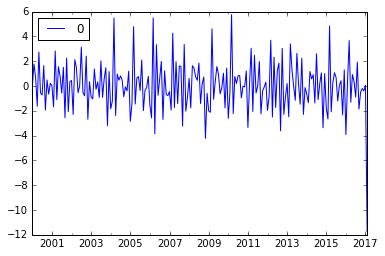

In [38]:
pd.DataFrame(components).plot()

## OLS for $\Lambda$ estimation

In [39]:
data.head()

,BZIPTLYo Index,MPMIBRMA Index,BZUETOTN Index,BFOETTOD Index,BZREELHT Index,BPPICM Index,BZPIIPCM Index,BZEXTOT$ Index,BZTBBALY INDEX,BZBXPBCM INDEX,BZRTFBSA INDEX,BZFGCCSA INDEX,ibov index,CL1 Comdty,BCSWLPD CURNCY,bcswfpd curncy,BZMOTRFB INDEX,BZJCGTOT INDEX,BZEANSA INDEX,OEBRD002 INDEX
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,0.431977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,NaN,NaN,NaN,NaN,NaN,NaN,-1.506142,1.320503,NaN,NaN,0.390118,NaN,1.182906,0.858100,NaN,0.851717,NaN,NaN,NaN,0.066661
2000-03-31,NaN,NaN,NaN,NaN,NaN,NaN,-0.853446,0.571225,NaN,NaN,-0.173015,NaN,0.041820,1.096984,NaN,-0.164548,NaN,NaN,NaN,0.278830
2000-04-30,NaN,NaN,NaN,NaN,NaN,NaN,-0.051211,-0.578228,NaN,NaN,-1.833671,NaN,-0.809702,-1.649797,NaN,-0.850857,NaN,NaN,NaN,-0.024076
2000-05-31,NaN,NaN,NaN,NaN,NaN,NaN,-4.688337,1.427010,1.13471,NaN,1.204858,NaN,1.071651,1.281271,NaN,1.898712,NaN,NaN,NaN,0.278789


In [40]:
def cleanData(df1,df2):
    df = pd.concat([df1, df2],axis=1)
    return df.dropna(axis=0)

In [41]:
coefList = []
for s in data.columns:
    clean = cleanData(data[s],components)
    coefList.append(sm.OLS(clean[s],clean[0]).fit().params[0])
for s in dataQ.columns:
    clean = cleanData(dataQ[s],components)
    coefList.append(sm.OLS(clean[s],clean[0]).fit().params[0])    

In [42]:
lambda0 = pd.DataFrame(coefList)

## AR for $A$ estimation

In [43]:
A0 = coefList.append(sm.tsa.ARMA(components.dropna(),(1,0)).fit().params[1])


In [44]:
# Z0 = Z
# Z0[0] = lambda0
# Z0.iloc[-1,1] = 2 * Z0.iloc[-1,0]
# Z0.iloc[-1,2] = 3 * Z0.iloc[-1,0]
# Z0.iloc[-1,3] = 2 * Z0.iloc[-1,0]
# Z0.iloc[-1,4] = 1 * Z0.iloc[-1,0]

# Z0 = Z0.apply(pd.to_numeric,axis=1)
# Z0 = Z0.apply(pd.to_numeric,axis=0)

# Estimation With Initial Values

In [45]:
#  Spent a lot of time struggling here. 
# the size of the Z0 is actually the size of the non fixed parameters
Z0 = lambda0
Z0 = Z0.apply(pd.to_numeric,axis=1)
Z0 = Z0.apply(pd.to_numeric,axis=0)

# Next two lines are only useful when the restriction is effective
Z0 = Z0 * (1/Z0.iloc[0,0]) 
Z0.drop(0,axis=0,inplace=True)

Z0

,0
1,-0.144885
2,-0.163762
3,-0.072801
4,-0.258506
5,-0.075967
6,-0.182365
7,1.049410
8,0.375688
9,0.478731
10,0.044493


In [46]:
x0i = np.zeros((m,1))
x0i[0,0] = components[0][0]
x0i = pd.DataFrame(x0i)
x0i

,0
0,-0.025409
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000


In [47]:
Z0i = Z0.as_matrix().T.flatten()

In [48]:
x0i = x0i.as_matrix().flatten()

In [81]:
print(dt.datetime.now())

2017-02-20 16:41:31.906330


In [82]:
%%R -i Zi,Bi,yi,Z,Qi,m,n,Z0i,x0i -o states,states1


Zi=matrix(Zi,n,m)
x0i=matrix(x0i,m,1)
Bi=matrix(Bi,m,m)
Qi=matrix(Qi,m,m)


# Z0i=matrix(Z0i,n,1)
Z0i=matrix(Z0i,n-1,1) # Use this when the restriction is effective

# print(dim(Z0i))
# print(dim(Zi))
# print(dim(Bi))
# print(dim(Qi))
# print(x0i)

print("START")

# model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero",x0="zero"
#                ,U="zero"
#                ,R="diagonal and unequal")


model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero"
               ,x0=x0i
#                ,x0="zero"
               ,U="zero"
               ,R="diagonal and equal")


inits = list(Z=Z0i,x0=0)
# print(Z0i)
# print(Zi)
# kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(maxit=5,
#                                                 conv.test.slope.tol=0.00001,
#                                                 abstol=0.00001))
kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(minit=1,maxit=300
#                                                 conv.test.slope.tol=0.3
#                                                 abstol=0.5, 
#                                                 allow.degen=TRUE
#                                                 MCInit=TRUE,
#                                                 numInits=100,
#                                                 numInitSteps=20
                                                           ))
# kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(minit=1,maxit=30))
# kemfit = MARSS(yi, model=model.gen,inits=inits,fit=TRUE)
# kemfit = MARSS(yi, model=model.gen,fit=FALSE)

# print(kemfit$par$Z)
states1 = kemfit$states
states = print(kemfit)
states = print(kemfit, what="model")
# message(kemfit, what="model")
# print(kemfit, what="start")
# print(kemfit, what="states")
# print(kemfit, what="ytT")
# print(kemfit, what="states.se")
# print(kemfit, what="kfs")
# print(kemfit$par$Z)
# message("porra")
# states=""
# cat("teste")

In [83]:
print(dt.datetime.now())

2017-02-20 17:26:52.807823


* x0 - Done
* normalizar as séries antes - fazer o check. data.mean e etc
* Initial MC - Bug

In [79]:
df1 = pd.DataFrame(states1).T

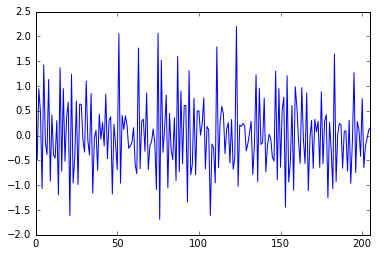

In [80]:
df1[1].plot()

In [84]:
df2 = pd.DataFrame(states1).T

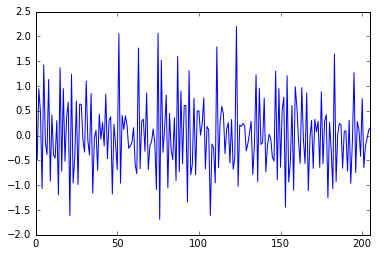

In [85]:
df2[1].plot()

In [88]:
(df1[1]-df2[1]).sum()

0.0